In [19]:
import sys
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
sys.path.append('/Users/46h/Research/btf/se-template/')
import scan_patterns as sp
from scipy import ndimage

import proplot as pplt
pplt.rc['grid'] = False
CMAP = 'viridis'
pplt.rc['cmap.sequential'] = CMAP
pplt.rc['cmap.discrete'] = False

In [20]:
datadir = './Diagnostics/Data/Measurements/2022-04-27/'
os.listdir(datadir)

['220427163645-x2d-slit.h5',
 '220427155227-x2d-slit.h5',
 '220427170354-x2d-slit.h5',
 '220427152517-x2d-slit.h5',
 '220427143259-image_on_demand.h5',
 '220427151929-y1d-vs06.h5',
 '220427151311-y1d-vs06.h5']

In [21]:
filename = '220427152517-x2d-slit.h5'
camname = 'cam34'
ny = 612
nx = 512

In [22]:
file = h5py.File(join(datadir, filename), 'r')
data = file['scandata']

attrs = data.dtype.names
print('attrs:')
for attr in attrs:
    print('  ', attr)
    
acts = attrs[6:]
print('acts:')
for act in acts:
    print('  ', act)

sdiag = np.array(attrs)[[2, 4, 5]]
print('sdiag:', sdiag)

signame = f'{camname}_integral'
print('signame:', signame)

attrs:
   timestamp
   iteration
   bcm04
   cam34_image
   cam34_saturation
   cam34_integral
   xp_PositionSync
   x_PositionSync
acts:
   xp_PositionSync
   x_PositionSync
sdiag: ['bcm04' 'cam34_saturation' 'cam34_integral']
signame: cam34_integral


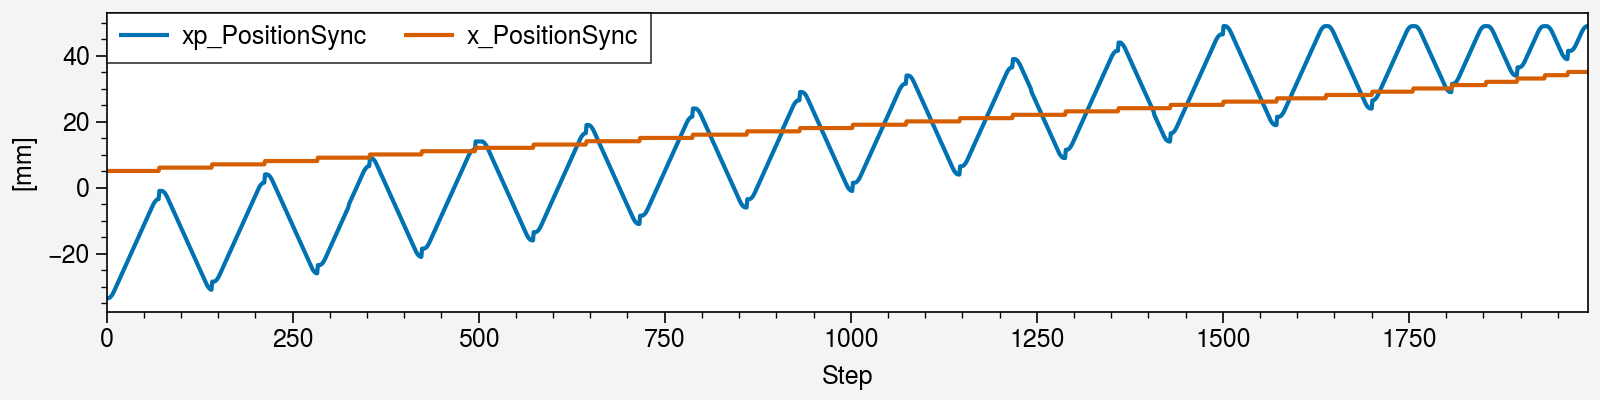

In [23]:
fig, ax = pplt.subplots(figsize=(8, 2))
for act in acts:
    ax.plot(data[:, act], marker=None, label=act)  # plt.plot(tpred,act3,':',color='C2')
ax.legend()
ax.format(xlabel='Step', ylabel='[mm]')

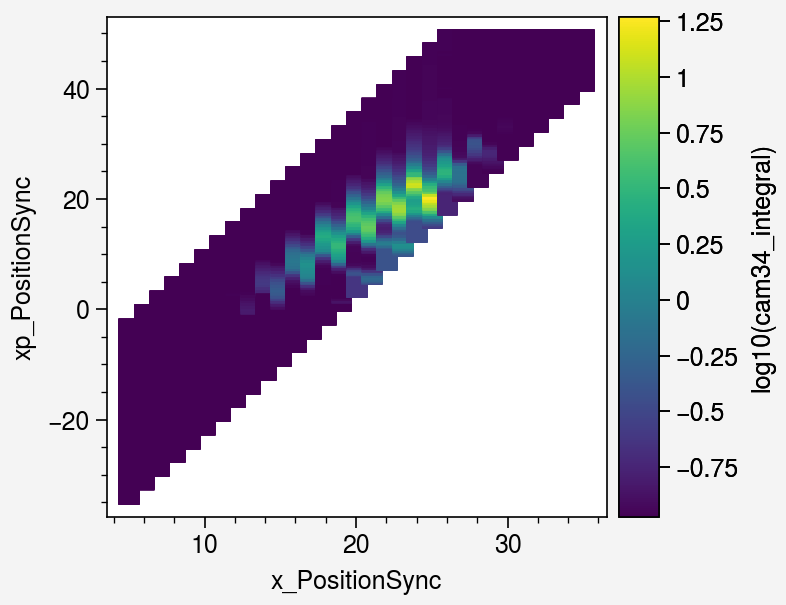

In [24]:
fig, ax = pplt.subplots()
ax.scatter(data[:, acts[1]], data[:, acts[0]], marker='s', s=50,
           c=np.log10(data[:, signame]), cmap=CMAP, 
           colorbar=True, colorbar_kw=dict(label=f'log10({signame})'))
ax.format(xlabel=acts[1], ylabel=acts[0])
plt.savefig('_output/x2d')

Diagnostic: bcm04
Max = -29.723
Min = -30.256
Mean = -29.988


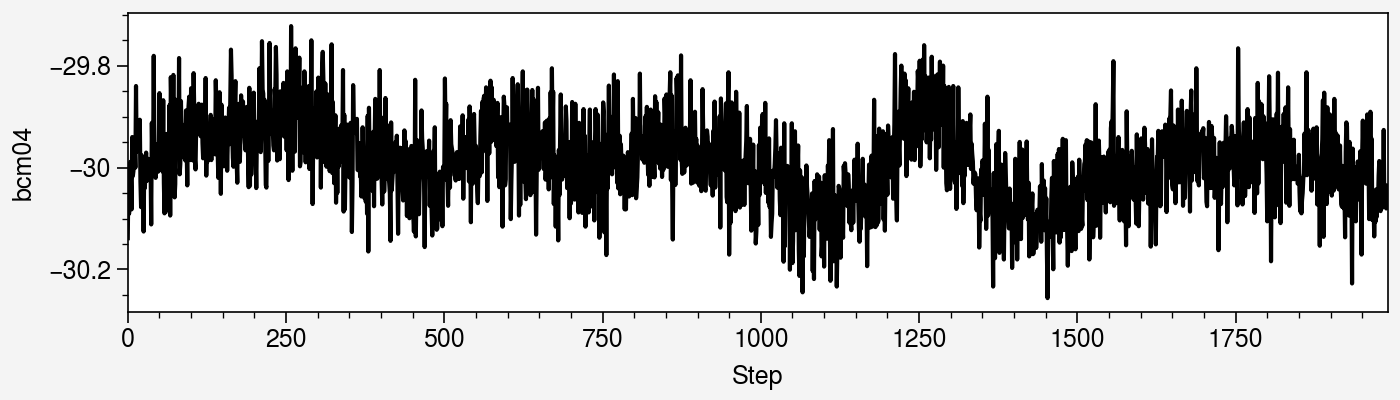

Diagnostic: cam34_saturation
Max = 1.000
Min = 0.002
Mean = 0.051


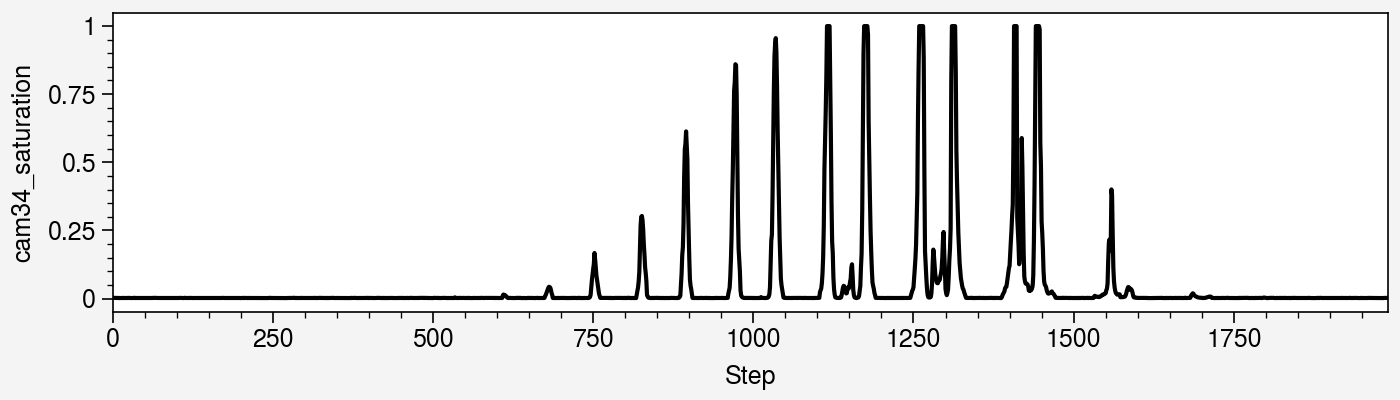

Diagnostic: cam34_integral
Max = 18.583
Min = 0.107
Mean = 0.365


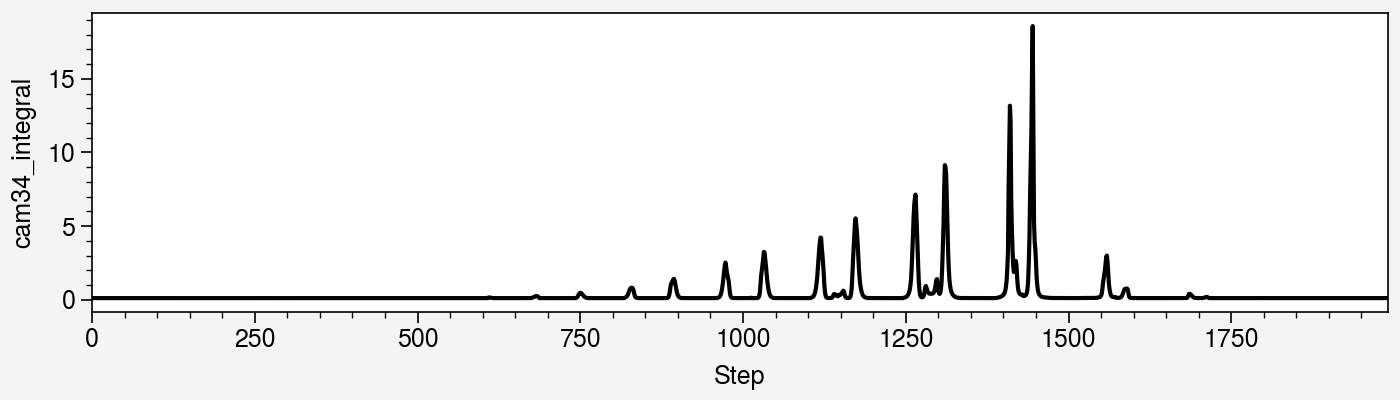

In [25]:
for item in sdiag:
    print(f'Diagnostic: {item}')
    print('Max = {:.3f}'.format(np.max(data[:, item])))
    print('Min = {:.3f}'.format(np.min(data[:, item])))
    print('Mean = {:.3f}'.format(np.mean(data[:, item])))
    fig, ax = pplt.subplots(figsize=(7.0, 2.0))
    ax.plot(data[:, item], color='black', marker='.', ms=0, label=item)
    ax.format(xlabel='Step', ylabel=item)
    plt.show()

#### Pick frames for background calculation

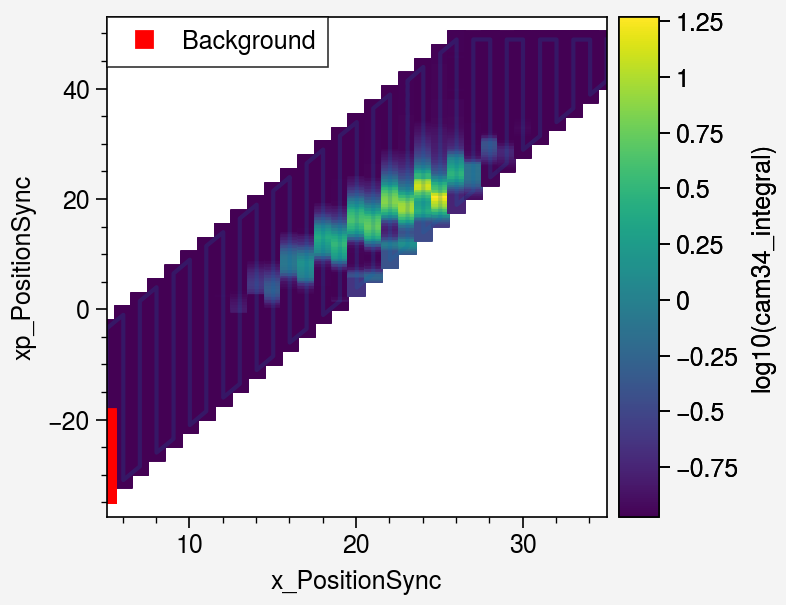

In [26]:
bgidx = np.arange(1, 35)

fig, ax = pplt.subplots()
ax.plot(data[:, acts[1]], data[:, acts[0]], alpha=0.2)
ax.scatter(data[:, acts[1]], data[:, acts[0]], marker='s', 
           c=np.log10(data[:, signame]), cmap=CMAP,
           colorbar=True, colorbar_kw=dict(label=f'log10({signame})'))

ax.plot(data[bgidx, acts[1]], data[bgidx, acts[0]], 'rs', label='Background')
ax.legend()
ax.format(xlabel=acts[1], ylabel=acts[0])

## Threshold and background


Background level from integral: 0.107213
Est. D.R. 10^-2.239


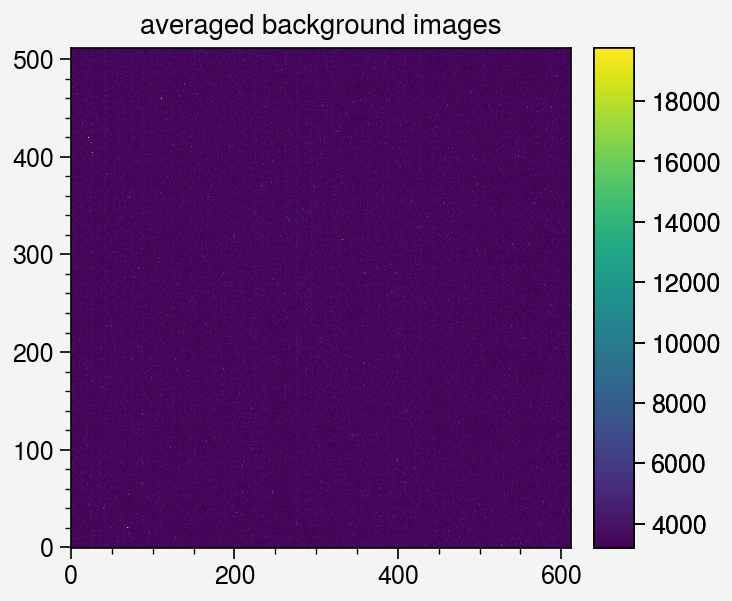

In [27]:
bg_lvl_est = np.max(data[bgidx, signame])
print(f'Background level from integral: {bg_lvl_est:.6f}')

thr_lvl_est = bg_lvl_est / np.max(data[:, signame])
print(f'Est. D.R. 10^{np.log10(thr_lvl_est):.3f}')

bg_mean = data[0, f'{camname}_image']
for i in bgidx[1:]:
    bg_mean += data[i, f'{camname}_image']
    
nbg = len(bgidx)
bg_mean = bg_mean / nbg
bg_ima = np.reshape(bg_mean,[nx,ny])

fig, ax = pplt.subplots()
ax.pcolormesh(bg_ima, colorbar=True)
ax.format(title='averaged background images')

In [28]:
w = data[:, signame]
thr = 0.043
w[w < thr] = 0.0
print(f'signame = {signame}')
print('Est 4D dynamic range 10^%.3f'%np.log10(thr / max(w)))

signame = cam34_integral
Est 4D dynamic range 10^-2.636


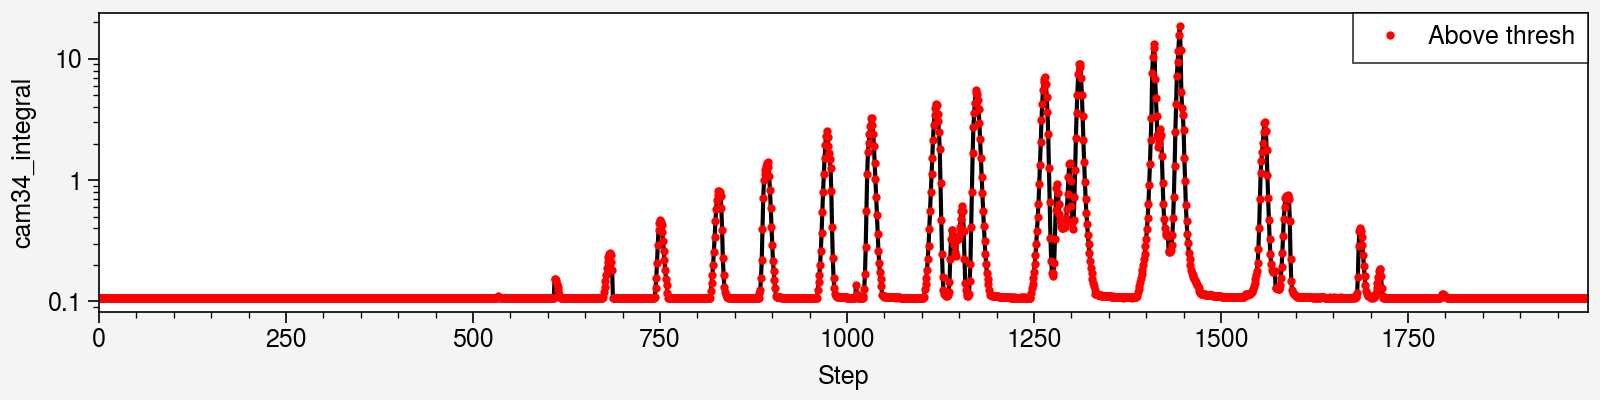

In [29]:
fig, ax = pplt.subplots(figsize=(8.0, 2.0))
ax.semilogy(data[:, signame], color='black')
ax.semilogy(w, marker='.', s=4, color='red', lw=0, label='Above thresh')
ax.legend()
ax.format(xlabel='Step', ylabel=signame)

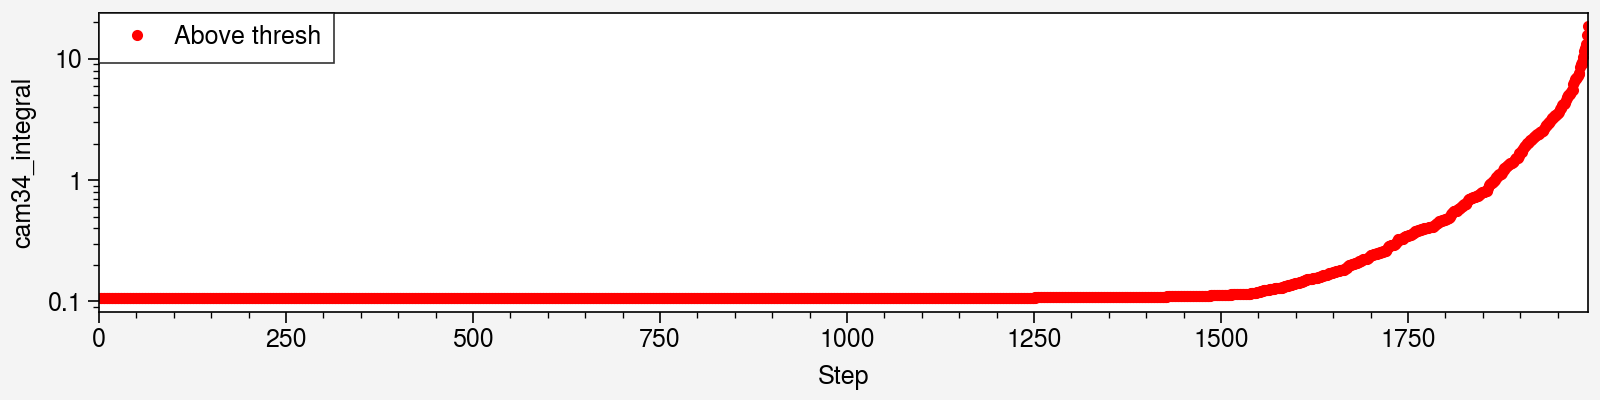

In [30]:
fig, ax = pplt.subplots(figsize=(8.0, 2.0))
ax.semilogy(np.sort(data[:, signame]), color='black')
ax.semilogy(np.sort(w), marker='.', color='red', lw=0, label='Above thresh')
ax.legend()
ax.format(xlabel='Step', ylabel=signame,)

### Plot measurement with threshold

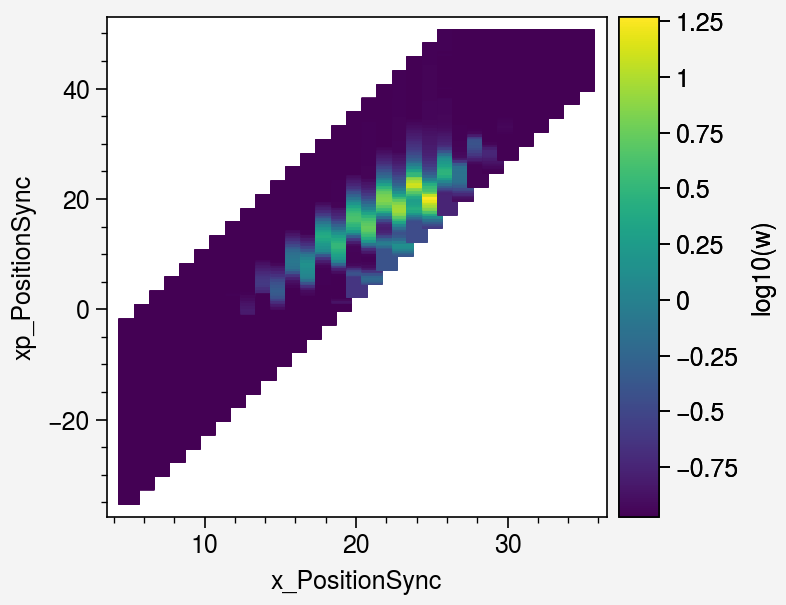

In [31]:
fig, ax = pplt.subplots()
ax.scatter(data[:, acts[1]], data[:, acts[0]], marker='s', s=50,
           c=np.log10(w), cmap=CMAP, 
           colorbar=True, colorbar_kw=dict(label='log10(w)'))
ax.format(xlabel=acts[1], ylabel=acts[0])

### Frame with peak signal

In [32]:
idx = np.argmax(w)
max_pixel = np.max(data[idx, f'{camname}_image'])

print('peak: ')
for item in list(acts) + list(sdiag):
    print(f'  {item} = {data[idx, item]:.3f} [mm]')
print(f'Max pixel: {max_pixel}')

peak: 
  xp_PositionSync = 21.794 [mm]
  x_PositionSync = 25.052 [mm]
  bcm04 = -30.088 [mm]
  cam34_saturation = 1.000 [mm]
  cam34_integral = 18.583 [mm]
Max pixel: 13100800


### Estimate dynamic range by examining frame with peak signal

In [33]:
camimage = f'{camname}_image'

In [34]:
idx = np.argmax(w)
im = np.reshape(data[idx, camimage], [nx, ny])
pix_max = np.max(im)
print(f'Max pixel value {pix_max}')

Max pixel value 13100800


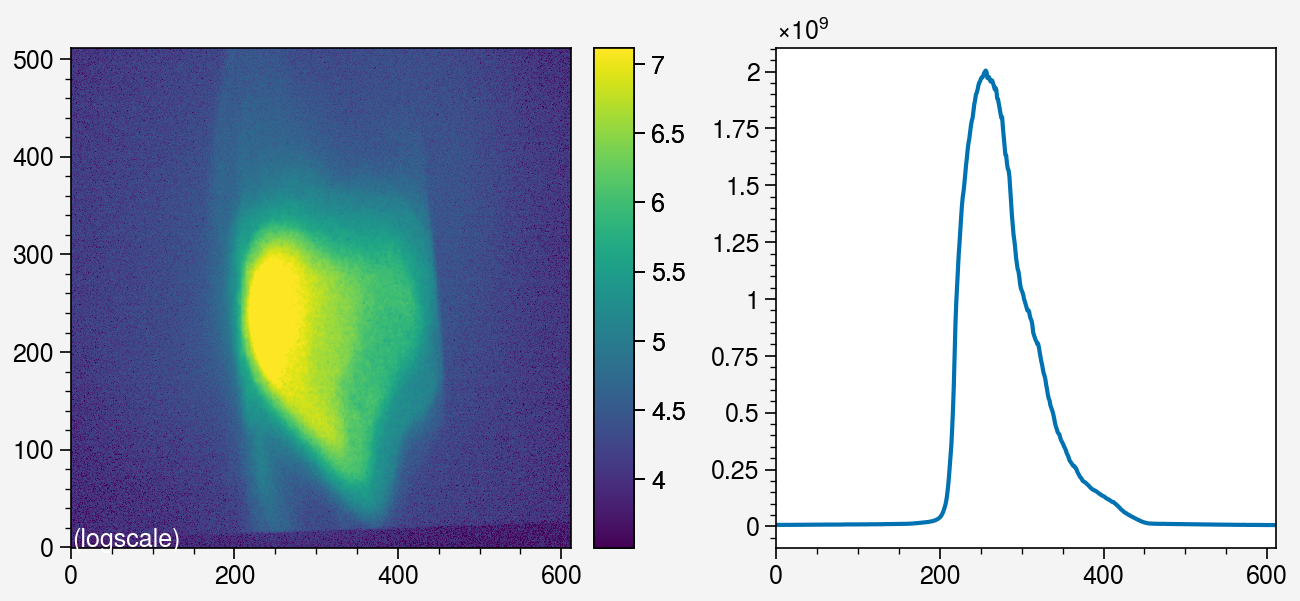

In [35]:
fig, axes = pplt.subplots(ncols=2, sharey=False)
axes[0].pcolormesh(np.log10(im), colorbar=True)
axes[0].annotate('(logscale)', xy=(1, 1), color='white')
axes[1].plot(np.sum(im, axis=0))
plt.show()

In [36]:
mask = np.ones(np.shape(im))
mask[400:, :] = 0.0
mask[:100, :] = 0.0
mask[:, 480:] = 0.0
mask[:, :200] = 0.0
immask = im * mask

print('5D DR: 10^%.3f'%(np.log10(np.max(mask * bg_ima) / np.max(immask))))
print('4D DR: 10^%.3f'%(np.log10(np.sum(mask * bg_ima) / np.sum(immask))))

5D DR: 10^-2.940
4D DR: 10^-2.793


/Users/46h/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


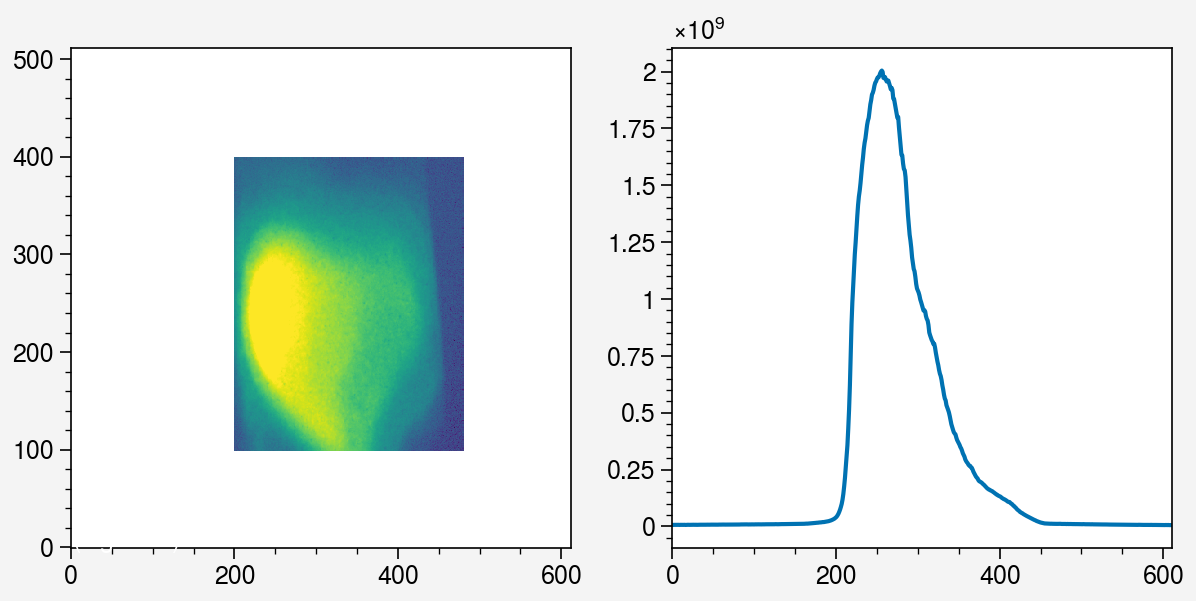

In [37]:
fig, axes = pplt.subplots(ncols=2, sharey=False)
axes[0].pcolormesh(np.log10(immask))
axes[0].annotate('(logscale)', xy=(1, 1), color='white')
axes[1].plot(np.sum(im, axis=0))
plt.show()

/Users/46h/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


naive 5D DR: 10^-2.117
naive 4D DR: 10^-6.268
5D DR: 10^-2.821
4D DR: 10^-2.240


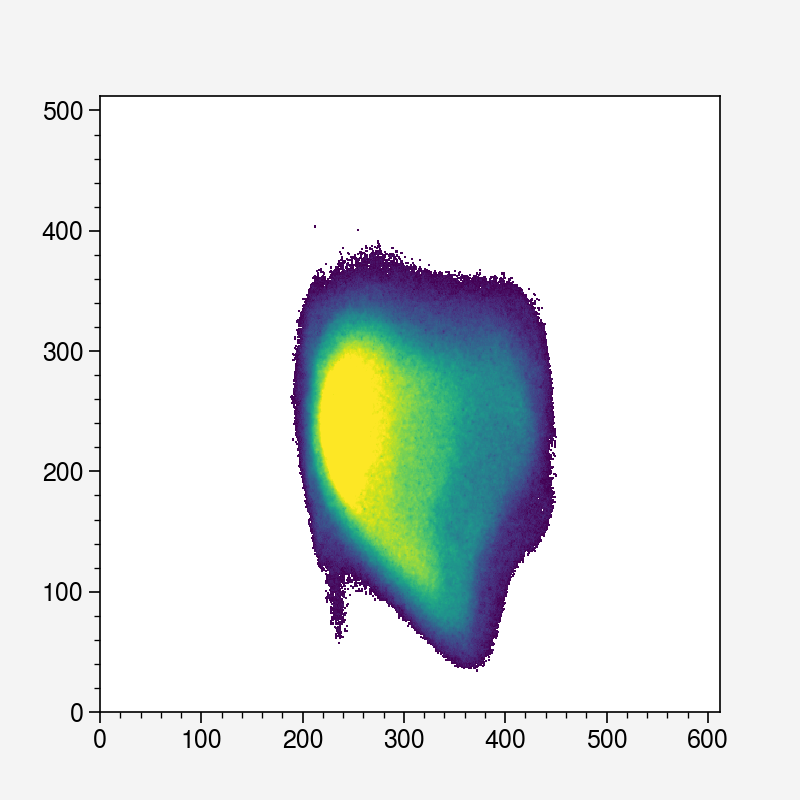

In [38]:
thr2 = 1e5

plt.figure()
imathr = im.copy()
imathr[imathr < thr2] = 0.0
plt.pcolor(np.log10(imathr))

print('naive 5D DR: 10^%.3f'%(np.log10(thr2/imathr.max())))
print('naive 4D DR: 10^%.3f'%(np.log10(thr2/imathr.sum())))
print('5D DR: 10^%.3f'%(np.log10(bg_ima.max()/im.max())))
print('4D DR: 10^%.3f'%(np.log10(bg_ima.sum()/im.sum())))

#### Threshold after smoothing

/Users/46h/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


naive 5D DR: 10^-2.418
naive 4D DR: 10^-6.571
5D DR: 10^-2.821
4D DR: 10^-2.240


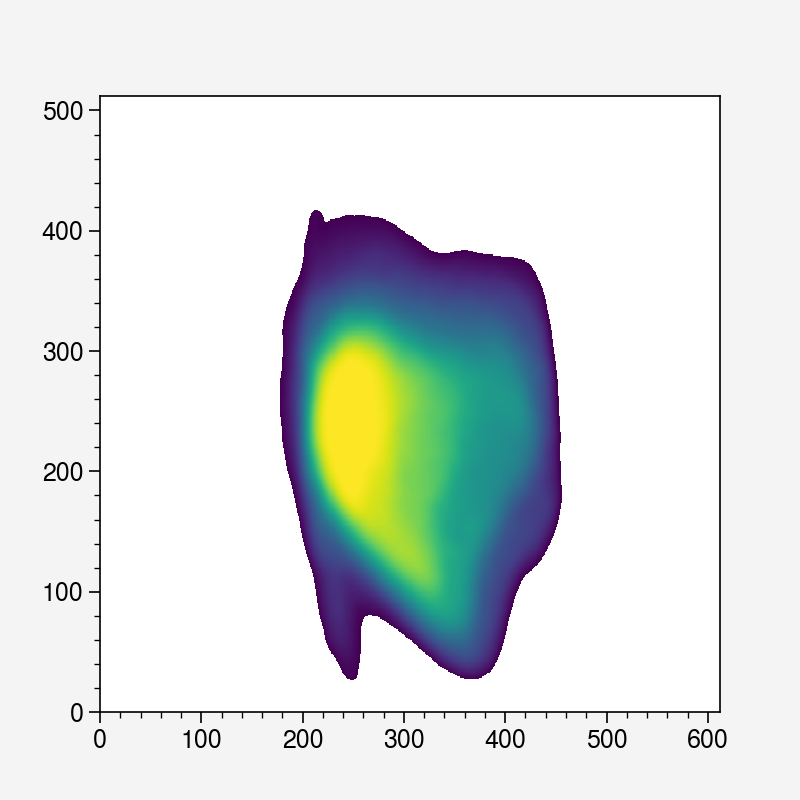

In [39]:
ima = im
ima_smooth = ndimage.gaussian_filter(ima, 5, mode='nearest')

thr2 = 50000.0
plt.figure()
imathr = ima_smooth.copy()
imathr[imathr < thr2] = 0.0
plt.pcolor(np.log10(imathr))

print('naive 5D DR: 10^%.3f'%(np.log10(thr2/imathr.max())))
print('naive 4D DR: 10^%.3f'%(np.log10(thr2/imathr.sum())))
print('5D DR: 10^%.3f'%(np.log10(bg_ima.max()/ima.max())))
print('4D DR: 10^%.3f'%(np.log10(bg_ima.sum()/ima.sum())))

## Measure against new scan boundaries

Make a list of coordinates that have signal.

In [40]:
pts = np.vstack([data[:, acts[0]], data[:, acts[1]]]).T
idx, = np.where(w > 0.0)
sigpts = pts[idx, :]

In [41]:
ndim = 2
M = np.identity(ndim)
M[0, 1] = 2.5
slit_dict = {
    'x': {
        'pvname':'ITSF_Diag:Slit_VT34a',
        'center':18,  # 19
        'distance':25,  # 26
        'steps':26,  # d1_distance
        'min':-6,
        'max':40
    },
    'xp': {
        'pvname':'ITSF_Diag:Slit_VT34b',
        'center':22,  # 22
        'distance':24,  # 24
        'steps':24,
        'min':-5,
        'max':40
    }
}
keys = list(slit_dict)
reprate = 5
navg = 10

In [42]:
def gen(): 
    
    center = np.array([slit_dict[keys[i]]['center'] for i in range(ndim)])
    distance = np.array([slit_dict[keys[i]]['distance'] for i in range(ndim)])
    nsteps = np.array([slit_dict[keys[i]]['steps'] for i in range(ndim)])
    stepsize = distance / nsteps

    start = center -0.5*distance
    taking_step = [False,]*ndim
    step_counter = [0,]*ndim
    
    # -- if sweeper scan, adjust step parameters for first actuator
    if navg == 0: 
        sweep_speed = stepsize[0]*reprate
        stepsize[0] = distance[0]
        nsteps[0] = 1

    # -- scan is complete after <npoints> steps
    npoints = 1
    for i in range(ndim):
        npoints *= (nsteps[i]  +1 )

    # start loop
    taking_step[0] = True
    counter = 0
    lastpoint = start
    while counter < npoints:
        # print('%i / %i, %.1f%%'%(counter,npoints,counter*100./npoints))
        # -- send actuators to starting point
        # -- this is only needed for stepper scan
        if (counter == 0) & (navg > 0):
            counter += 1
            # -- cast int sheared frame first:
            nextactpoint = np.matmul(M,lastpoint - center) + center
            # don't let slit destination exceed min/max specified in slit_dict
            # skip points that exceed this limit, but otherwise do not change scan
            skipFlag = False
            for i in range(ndim):
                if (nextactpoint[i] > slit_dict[keys[i]]['max']) or (nextactpoint[i] < slit_dict[keys[i]]['min']):
                    skipFlag = True
            if not(skipFlag):    
                cmd = list(nextactpoint)
                yield cmd, navg
                
        counter += 1
        thisstep = [0,]*ndim
        for i in range(ndim):
            # -- if end of line has been reached
            if step_counter[i] >= nsteps[i]:
                # -- stop stepping this actuator
                taking_step[i] = False
                # -- and make sure the next actuator knows it's time to step
                taking_step[int(np.mod(i+1,ndim))] = True
                # -- and roll over the stepcounter
                step_counter[i] = np.mod(step_counter[i],nsteps[i])
                # -- while also reversing direction of step
                stepsize[i] *= -1
            # -- if end of line has not been reached
            elif taking_step[i]:
                # -- take the next assigned step
                thisstep[i] += stepsize[i]
                # -- add one to step_counter
                step_counter[i] += 1

                # -- now that a step has been taken, stop until your turn comes up again 
                # unless you're the first actuator; that guy always steps
                if i > 0:
                    taking_step[i] = False
                    taking_step[0] = True

            # -- exit loop if an actuator has stepped
            if thisstep[i] != 0:
                break

        # -- get startpoint in actuator coordinates
        startactpoint = np.matmul(M,lastpoint - center) + center
        # -- progress 1 step
        lastpoint = lastpoint + thisstep
        # -- cast into actuator coordinates (sheared frame)
        nextactpoint = np.matmul(M,lastpoint - center) + center
        
        ##### deal with points outside slit min/max limits.
        # -- distinguish between steppers, sweepers
        isweep = []
        if navg != 0: # all steppers if averaging is on
            istep = range(ndim)
        else: 
            istep = []; 
            for j in range(0,ndim):
                dxj =  np.abs(nextactpoint[j] - startactpoint[j])
                if dxj == 0: # if distance == 0, this point is a stepping point
                    istep.append(j)
                else:
                    isweep.append(j)
                    
        # step scan: skip points that exceed this limit, but otherwise do not change scan
        skipFlag = False
        for i in istep:
            if (nextactpoint[i] > slit_dict[keys[i]]['max']) or (nextactpoint[i] < slit_dict[keys[i]]['min']):
                skipFlag = True   
        # sweep scan; this will result in odd behavior if there is > 1 sweeper.
        for i in isweep:
            if (startactpoint[i] > slit_dict[keys[i]]['max']):
                startactpoint[i] = slit_dict[keys[i]]['max']
                print('%i sweep shortened on max end'%counter)
            if (startactpoint[i] < slit_dict[keys[i]]['min']):
                startactpoint[i] = slit_dict[keys[i]]['min']
                print('%i sweep shortened on minend'%counter)
            if (nextactpoint[i] > slit_dict[keys[i]]['max']):
                nextactpoint[i] = slit_dict[keys[i]]['max']
                print('%i sweep shortened on max end'%counter)
            if (nextactpoint[i] < slit_dict[keys[i]]['min']):
                nextactpoint[i] = slit_dict[keys[i]]['min']
                print('%i sweep shortened on minend'%counter)

        ##### STEPPER SCAN COMMAND
        if (navg > 0) & (not(skipFlag)):
            cmd = list(nextactpoint)
            yield cmd ,navg

        ##### SWEEPER SCAN COMMAND
        elif (navg == 0) & (not(skipFlag)): 
            # -- skip step if sweeper is not moving
            if thisstep[0] == 0:
                continue
            # -- send command if sweeper is moving on this step
            else:                
                # -- sweeper command
                cmd = []
                startpt = startactpoint[0]#np.min([startactpoint[0],49])
                endpt = nextactpoint[0]#np.min([nextactpoint[0],49])
                cmd.append((startpt,endpt,sweep_speed))
                # -- commands for the rest of the actuators
                for j in range(1,ndim):
                    # if slope, stepper may have to sweep as well
                    stepper_speed = sweep_speed * np.abs(nextactpoint[j] - startactpoint[j]) / d1_distance
                    cmd.append((startactpoint[j],nextactpoint[j],stepper_speed))
            lastcmd = cmd.copy() # -- copy command in case it needs repeated
            yield cmd

In [43]:
# -- run points generator

# -- re-arrange array
#  sweeping
# genpts = np.array(list(gen()))
# newpts = np.zeros([np.shape(genpts)[0]*2,ndim])
# for i in range(ndim):
#     newpts[:,i] = genpts[:,i,0:2].flatten()

# averaging
lgen= list(gen())
newpts = np.zeros([len(lgen), ndim])
for i in range(len(lgen)):
    newpts[i, :] = lgen[i][0]
    
# Un-shear new (generated) points.
center = np.array([slit_dict[keys[i]]['center'] for i in range(ndim)])
Minv = np.linalg.inv(M)
newpts_n = np.zeros(np.shape(newpts))
for row in range(np.shape(newpts)[0]):
    newpts_n[row, :] = np.matmul(Minv, newpts[row, :] - center) + center
    
# Un-shear signal points.
sigpts_n = np.zeros(sigpts.shape)
for row in range(np.shape(sigpts)[0]):
    sigpts_n[row, :] = np.matmul(Minv, sigpts[row, :] - center) + center

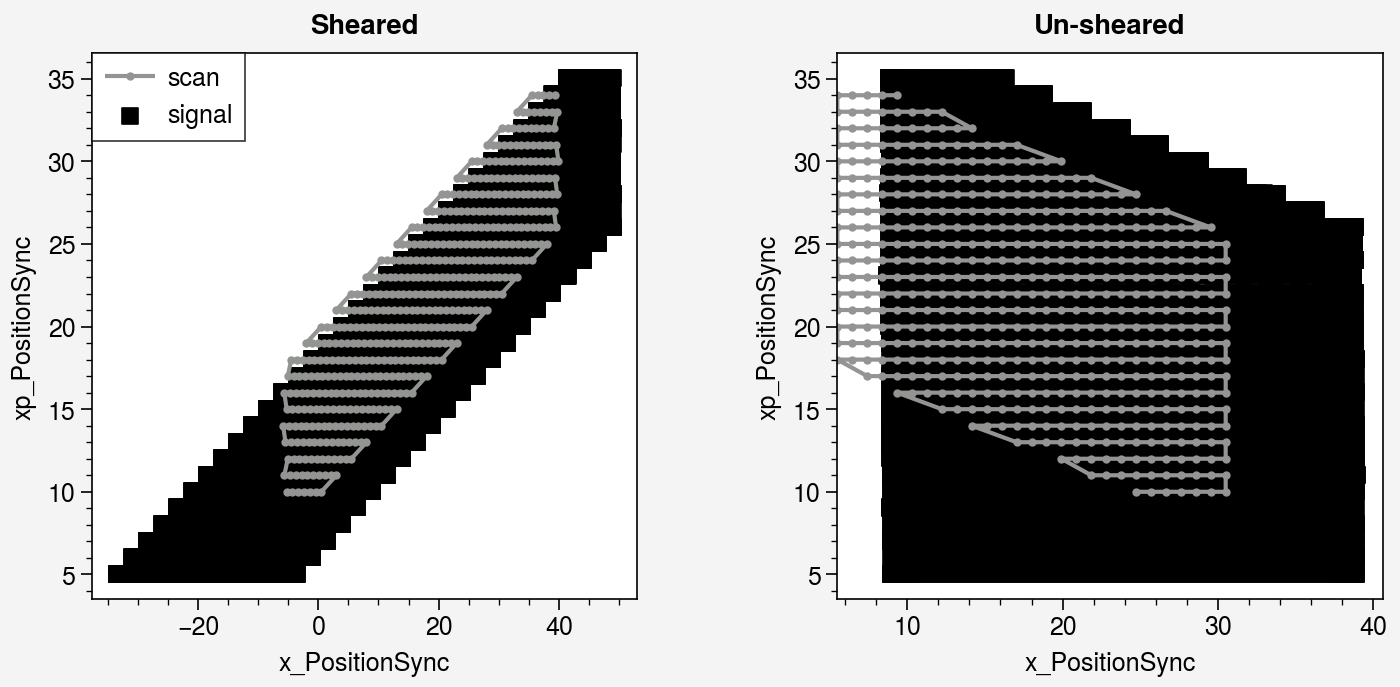

In [44]:
fig, axes = pplt.subplots(ncols=2, sharex=False, sharey=False,
                          wspace=8.0, figwidth=7.0)
for ax, signal, new in zip(axes, [sigpts, sigpts_n], [newpts, newpts_n]):
    ax.scatter(signal[:,0], signal[:,1], marker='s', color='black', label='signal')
    ax.plot(new[:, 0], new[:, 1], marker='.', s=4, color='grey', label='scan');
axes.format(xlabel=acts[1], ylabel=acts[0], toplabels=['Sheared', 'Un-sheared'])
axes[0].legend(ncols=1)
plt.show()